## import

In [18]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image, overlay_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers

from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.lr_aspp import MobileNetV3Seg

from tqdm import tqdm

# setting

In [19]:
artifacts_path = Path("../../artifacts/mobilenetv3-lraspp")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [20]:
DEVICE = torch.device("cuda:0")

# data

In [21]:
FACTOR: int = 2
BATCH_SIZE = 4 * (2 * FACTOR if FACTOR > 1 else FACTOR)
TRAIN_IMAGE_SIZE = (1024 //FACTOR, 2048 // FACTOR)
TEST_IMAGE_SIZE = (1024 // FACTOR, 2048 // FACTOR)
NUM_CLASS = len(VOC_CLASS_NAMES)

In [22]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(*TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(*TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [23]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [24]:
NUM_WORKERS = get_num_workers()

In [25]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

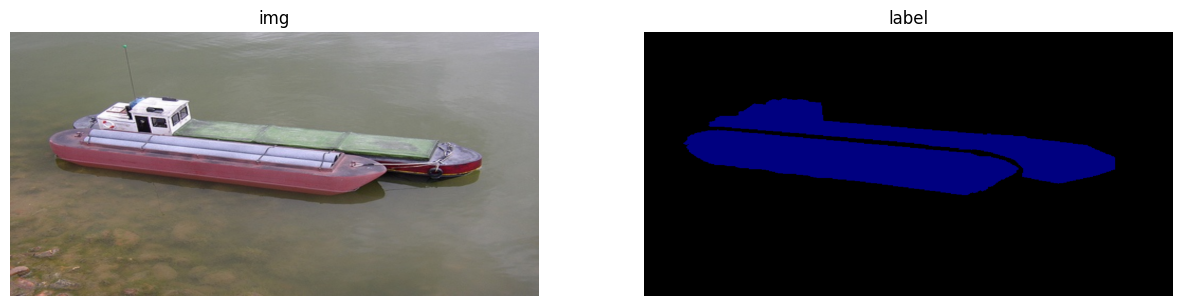

In [26]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [27]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([16, 3, 512, 1024])
torch.Size([16, 512, 1024])


# train

In [28]:
model = MobileNetV3Seg(
    output_size=NUM_CLASS + 1,
    # no effect, since mobile v3 is narrow
    hidden_dim=128,
    # pool parameters are optional, you can use default value
    # if use default, image size should be 1024 x 2048
    # formula is in LR-ASPP module source code
    pool_kernel_size=(17, 17),
    pool_stride=(16, 12),
    frozen_backbone=True,
).to(DEVICE)

In [29]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
MobileNetV3Seg                                          --
├─MobileNetFeatureExtractor: 1-1                        --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2dNormActivation: 3-1                   (464)
│    │    └─InvertedResidual: 3-2                       (464)
│    │    └─InvertedResidual: 3-3                       (3,440)
│    │    └─InvertedResidual: 3-4                       (4,440)
│    │    └─InvertedResidual: 3-5                       (10,328)
│    │    └─InvertedResidual: 3-6                       (20,992)
│    │    └─InvertedResidual: 3-7                       (20,992)
│    │    └─InvertedResidual: 3-8                       (32,080)
│    │    └─InvertedResidual: 3-9                       (34,760)
│    │    └─InvertedResidual: 3-10                      (31,992)
│    │    └─InvertedResidual: 3-11                      (31,992)
│    │    └─InvertedResidual: 3-12                  

In [30]:
EPOCHES = 30

In [31]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [32]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [34]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 182/182 [01:08<00:00,  2.65it/s]


epoch 1 : 0.10910643000605998


100%|██████████| 182/182 [01:07<00:00,  2.68it/s]


epoch 2 : 0.0417472853703977


100%|██████████| 182/182 [01:09<00:00,  2.62it/s]


epoch 3 : 0.035457189788448286


100%|██████████| 182/182 [01:06<00:00,  2.72it/s]


epoch 4 : 0.032347996094888386


100%|██████████| 182/182 [01:07<00:00,  2.70it/s]


epoch 5 : 0.030711957376327488


100%|██████████| 182/182 [01:07<00:00,  2.70it/s]


epoch 6 : 0.029249069444671438


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]


epoch 7 : 0.028132865768294414


100%|██████████| 182/182 [01:07<00:00,  2.70it/s]


epoch 8 : 0.027353383078761808


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]


epoch 9 : 0.026653706536188232


100%|██████████| 182/182 [01:06<00:00,  2.72it/s]


epoch 10 : 0.025830420890597852


100%|██████████| 182/182 [01:07<00:00,  2.68it/s]


epoch 11 : 0.025457724099876462


100%|██████████| 182/182 [01:05<00:00,  2.77it/s]


epoch 12 : 0.02480359561741352


100%|██████████| 182/182 [01:05<00:00,  2.78it/s]


epoch 13 : 0.024697885981627872


100%|██████████| 182/182 [01:05<00:00,  2.77it/s]


epoch 14 : 0.023960723731011806


100%|██████████| 182/182 [01:06<00:00,  2.75it/s]


epoch 15 : 0.02398212255070825


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]


epoch 16 : 0.022769483942333815


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]


epoch 17 : 0.02257597168580025


100%|██████████| 182/182 [01:07<00:00,  2.69it/s]


epoch 18 : 0.022387575706119066


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]


epoch 19 : 0.02249621739099314


100%|██████████| 182/182 [01:06<00:00,  2.74it/s]


epoch 20 : 0.02223766700026917


100%|██████████| 182/182 [01:07<00:00,  2.69it/s]


epoch 21 : 0.02234951598610688


100%|██████████| 182/182 [01:06<00:00,  2.73it/s]


epoch 22 : 0.022169444397869675


100%|██████████| 182/182 [01:07<00:00,  2.71it/s]


epoch 23 : 0.02216600276693538


100%|██████████| 182/182 [01:10<00:00,  2.59it/s]


epoch 24 : 0.022227780893445015


100%|██████████| 182/182 [01:10<00:00,  2.58it/s]


epoch 25 : 0.02199340542102908


100%|██████████| 182/182 [01:08<00:00,  2.66it/s]


epoch 26 : 0.02222047606483102


100%|██████████| 182/182 [01:10<00:00,  2.60it/s]


epoch 27 : 0.0222563367940813


100%|██████████| 182/182 [01:09<00:00,  2.63it/s]


epoch 28 : 0.022326059470587706


100%|██████████| 182/182 [01:08<00:00,  2.65it/s]


epoch 29 : 0.022292276849499443


100%|██████████| 182/182 [01:08<00:00,  2.66it/s]

epoch 30 : 0.022261594017906176


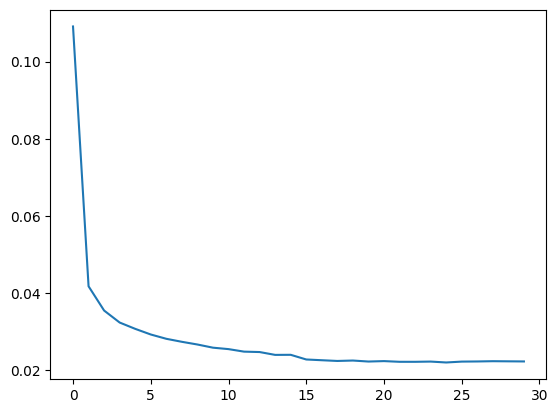

In [35]:
plt.plot(training_loss)

In [36]:
model_path = artifacts_path.joinpath('lraspp.mobilenetv3.pth')

In [37]:
torch.save(model.state_dict(), model_path)

In [38]:
get_file_size(model_path)

'11.72MiB'

In [39]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [40]:
from torchmetrics.classification import jaccard

In [41]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 40/40 [00:19<00:00,  2.10it/s]


In [42]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.55 
bicycle        : 0.2  
bird           : 0.7  
boat           : 0.42 
bottle         : 0.55 
bus            : 0.71 
car            : 0.62 
cat            : 0.69 
chair          : 0.23 
cow            : 0.57 
diningtable    : 0.53 
dog            : 0.55 
horse          : 0.51 
motorbike      : 0.59 
person         : 0.61 
pottedplant    : 0.26 
sheep          : 0.62 
sofa           : 0.34 
train          : 0.7  
tvmonitor      : 0.49 
----------------------
total          : 0.52 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

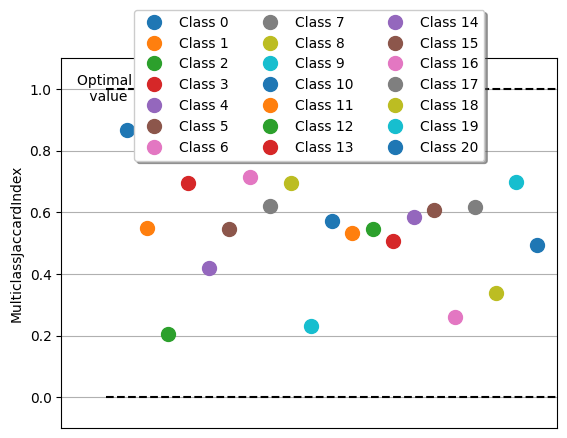

In [43]:
metric.plot()

### for image in dataset

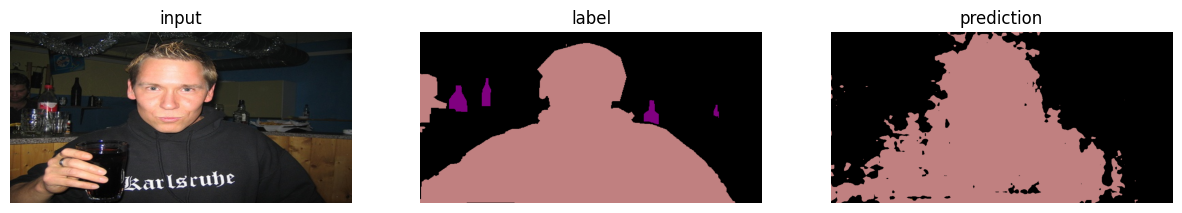

In [44]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

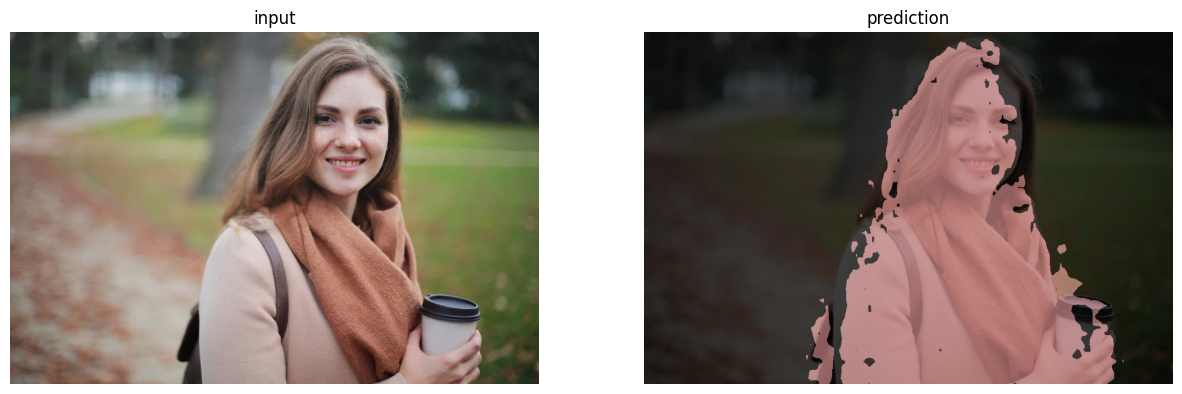

In [45]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

coef = 0.7
mask = decode_segmap(output, LABEL_COLORS)
overlaid = overlay_image(target_img, mask, coef)

plot_grids(
    [
        target_img,
        overlaid,
    ],
    ["input", "prediction"],
    1,
    2,
    figsize=(15, 15),
)